## PCA Example

This notebook is designed to familiarize you with a representative pixel-wise analysis workflow using the cluster at Janelia and Thunder. 

We will load data from disk that is formatted as a `Thunder.Series` object, meaning a collection of units of `((x,y,z),timeseries)` for each pixel `(x,y,z)`. These timeseries will be distributed over multiple machines on the cluster.

Next, we will segment the volumetric data into foreground (brain) and background using a simple heuristic.

After that we will perform PCA on the pixels corresponding to the brain, and visualize some of the results.

### Import necessary libraries

In [1]:
# Numpy provides vectors operatons
import numpy as np
# Matplotlib provides plotting
import matplotlib.pyplot as plt

# thresholding function for removing the background of the image
from skimage.filter import threshold_otsu as otsu

# thunder source extraction classes
from thunder import PCA

# This makes plots show up in the notebook
%matplotlib inline

### Specify the experiment to load from binary series format
Experiments with multiple colors will be stored such that there is one directory per color channel, starting with channel 0, e.g. ```/$experiment_name/CHN00/series/```

Conventionally, CHN00 is green emission (e.g. GCaMP) and CHN01 is red emission (e.g. RCaMP).

In [2]:
serDir = '/nobackup/ahrens/davis/data/spark/20150616/4dpf_cy163xcy221_F2_omr_1_20150616_225359/CHN00/series/'

### Load series data from disk and store in RAM on the cluster

In [3]:
# This ipython notebook command prints the time taken for running the cell. 
%%time

# Load series data and cache (store in RAM). This makes iterative factorization methods much faster. 
# The raw images are uint16, but series data have been normalized and thus are float16
# float16 data should be upcast to float32 before doing statistics
serDat = tsc.loadSeries(serDir).cache()

# serDat.first() and serDat.count() return the first element in an RDD and the number of elements in an RDD, respectively.
# Execution in Spark is lazy, so I call these two methods to ensure that the .cache() step occurs.
# In the event that you want to remove a cached dataset from RAM, call dataset.rdd.unpersist()
serDat.first()
serDat.count()

# print the dimensions of the data
dims = serDat.dims
print('dims = %r' %dims)

dims = Dimensions(values=[(0, 0, 0), (2047, 1023, 30)], n=3)


### Take the time average of the experiment, then collect the volume as an array
Note: I get a volume by using the `series.pack()` method, which converts the collection of `((x,y,z),data)` items into a single `[x,y,z,data]` array. This method doesn't work if you remove pixels / regions from the dataset!

In [5]:
%%time

# First convert float16 data to float32 to prevent overflow during averaging
# transpose this array so that plotting is a little simpler
meanVol = serDat.astype('float32').seriesMean().pack().T

CPU times: user 32.1 s, sys: 1.28 s, total: 33.4 s
Wall time: 45.6 s


### Plot max projection of mean volume

<matplotlib.colorbar.Colorbar instance at 0x4c2b998>

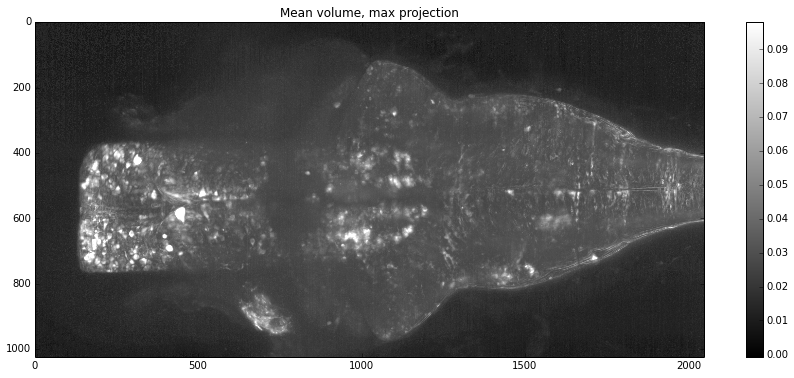

In [6]:
plt.figure(figsize=(15,6))
plt.imshow(meanVol.max(0), clim=np.percentile(meanVol.ravel(),[0,99.99]),cmap='gray')
plt.title('Mean volume, max projection')
plt.colorbar()

### It's helpful to remove the background of each image before doing any factorization.
I do this by estimating a threshold via the histogram of the mean volume.

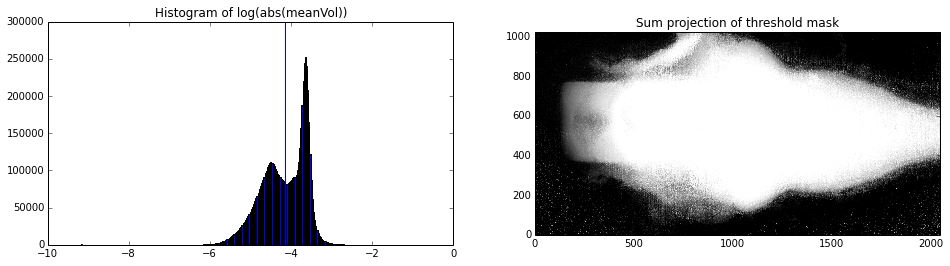

In [7]:
# to tweak the thresholding, adjust thScale
thScale = 1.1
thrO = np.exp(otsu(np.log(np.abs(meanVol.ravel()[::10])),1000)) * thScale

# downsampling in x,y, or z
dsxyz = [1,1,1]

# Optional: set these arrays to define a rectangular region of interest
xlims = range(0, dims[0], dsxyz[0])
ylims = range(0,dims[1],dsxyz[1])
zlims = range(0,dims[2],dsxyz[2])
cropxyz = [xlims, ylims, zlims]

# In order for all workers to access data, e.g. a list of coordinates to define an ROI, we need  
# to ship the data to all the workers by parallelizing it via the sc.broadcast() function
bc = sc.broadcast(cropxyz)

plt.figure(figsize = (16,4))
plt.subplot(121)
plt.hist(np.log(np.abs(meanVol.ravel()))[::10],300)
plt.axvline(np.log(thrO))
plt.title('Histogram of log(abs(meanVol))')

ax = plt.subplot(122)
mask = meanVol > thrO
plt.imshow(mask.sum(0), origin = 'bottom',cmap='gray')
plt.title('Sum projection of threshold mask')

[plt.axvline(cropxyz[0][x]) for x in [0,-1]]
[plt.axhline(cropxyz[1][y]) for y in [0,-1]]

### Filter via threshold and crop in space

In [8]:
%%time

filtDat = serDat.filterOnValues(lambda x: x.std() > thrO)
subDat = filtDat.filterOnKeys(lambda k: k[0] in bc.value[0] and k[1] in bc.value[1] and k[2] in bc.value[2])

# compute the mean of the entire brain 
serMean = subDat.astype('float32').mean()

### Plot the time average of the entire (thresholded, cropped) volume.
Optionally select a specific interval in the timeseries for factorization

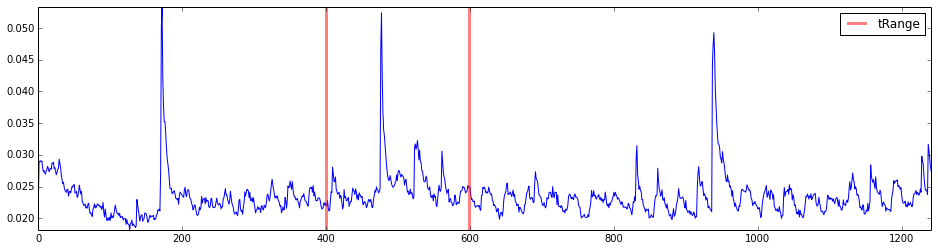

In [10]:
# This commented line would select the entire timeseries
#tRange = range(0,subDat.index[-1])
tRange = range(400,600)

plt.figure(figsize=(16,4))
plt.plot(serMean)
plt.axis('tight')
plt.axvline(tRange[0],color='r', label = 'tRange', linewidth= 3, alpha = .5)
plt.axvline(tRange[-1],color='r', linewidth = 3, alpha = .5)
plt.legend()

### Thresholding and cropping produce a smaller dataset than what was originally loaded. Clear the full series data from RAM and store our thresholded and cropped dataset instead.

In [11]:
%%time
serDat.rdd.unpersist()
subDat = filtDat.select(tRange).astype('float32')
subDat.cache()
subDat.first()
subDat.count()

CPU times: user 430 ms, sys: 161 ms, total: 591 ms
Wall time: 1min 41s


### Perform PCA on the data

In [12]:
%%time
pcaDat = PCA(k=20, svdMethod='em').fit(subDat)

CPU times: user 17.2 s, sys: 6.21 s, total: 23.4 s
Wall time: 3min 56s


### Visualize the top 10 temporal basis functions

(0.0, 199.0, -4.0620533154986971, 0.33858930378646662)

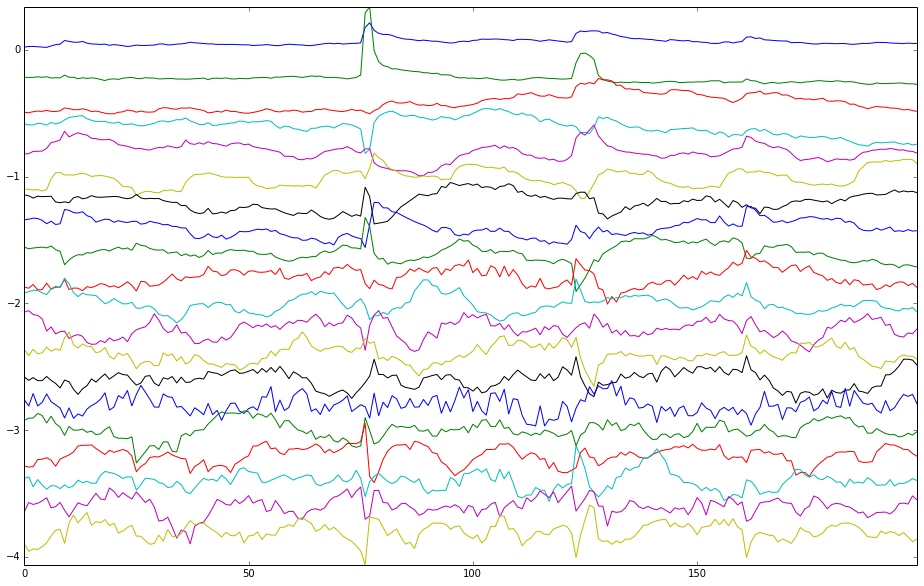

In [13]:
plt.figure(figsize=(16,10))
scale = .2
for ind,c in enumerate(pcaDat.comps):
    plt.plot(c - ind*scale)
plt.axis('tight')

### Visualize spatial weights

In [14]:
%%time

# This will be slow since it requires getting data off the worker machines
scores = pcaDat.scores.collect()

CPU times: user 2min 7s, sys: 9.72 s, total: 2min 17s
Wall time: 2min 29s


In [15]:
# Define a function to convert a list of (k,v) pairs into an array
def makeVol(dims, data, ind):
    vol = np.zeros(dims,dtype=data[0][1].dtype)
    for k,v in data:
        vol[k] = v[ind]
    return vol

In [16]:
# Get the weights for PCs in volume form
maps = [makeVol(dims, scores, x) for x in range(20)]

### Now to demonstrate how I visualize volumetric data
I project the data along one or two axes (Z and Y), usually taking the maximum for the projection. For data which can be positive or negative, e.g. PCA weights, I take the absolute value of the volume of weights before taking the maximum. 

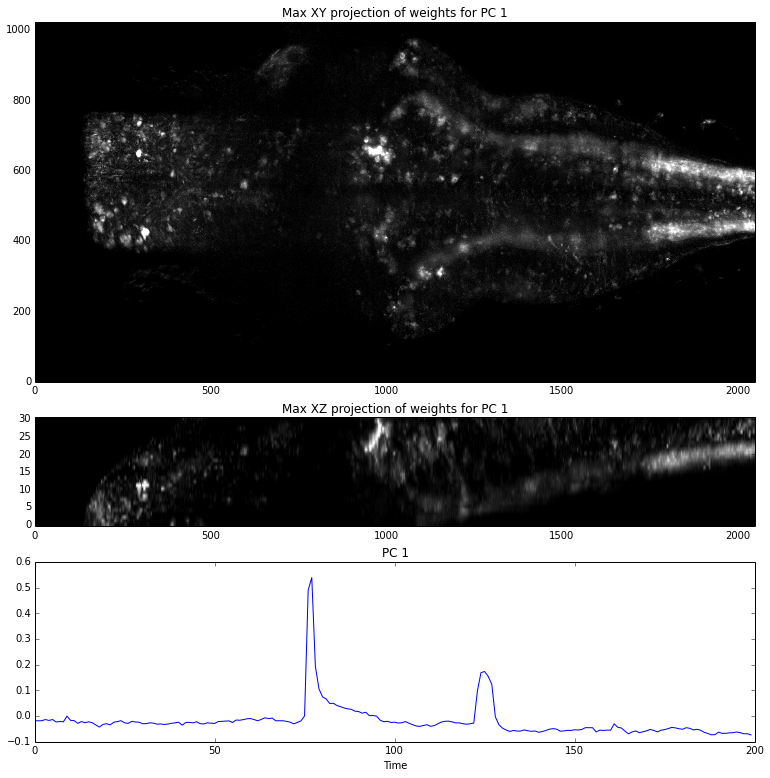

In [17]:
# Weight to visualize
w = 1

plt.figure(figsize=(10,10))
xyPlot = np.abs(maps[w]).max(2).T
xzPlot = np.abs(maps[w]).max(1).T

plt.subplot2grid((4,1),(0,0), rowspan=2)
plt.imshow(xyPlot, cmap = 'gray', clim = np.percentile(xyPlot,[50,99.9]), origin='bottom')
plt.title('Max XY projection of weights for PC %i' %w)

plt.subplot2grid((4,1),(2,0))
plt.imshow(xzPlot, cmap = 'gray', clim = np.percentile(xzPlot,[50,99.9]), origin='bottom', aspect=10)
plt.title('Max XZ projection of weights for PC %i' %w)

plt.subplot2grid((4,1),(3,0))
plt.plot(pcaDat.comps[w])
plt.xlabel('Time')
plt.title('PC %i' %w)
plt.subplots_adjust(0,0,1,1,0,0)